In [1]:
import sys
sys.path.append("/home/hoang/WorkSpace/centernet")

from src.datamodules.voc_datamodule import VOCDataModule

/home/hoang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hoang/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/hoang/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/hoang/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
dtm = VOCDataModule("../data", year="2007", batch_size=4)
dtm.setup()

Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar
Extracting ../data/VOCtrainval_06-Nov-2007.tar to ../data
Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar
Extracting ../data/VOCtrainval_06-Nov-2007.tar to ../data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


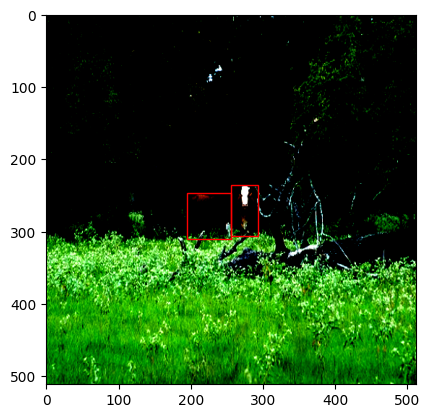

In [3]:
import matplotlib.pyplot as plt
import torch
from typing import Tuple

def plot_data(img: torch.Tensor, bboxes: torch.Tensor):
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
        plt.gca().add_patch(rect)
    plt.show()

for batch in dtm.train_dataloader():
    img, bboxes, labels = batch
    plot_data(img[0], bboxes[0])
    break

In [4]:
from src.models.centernet_module import CenterNet
from src.models.components.resnet import PoseResNet, BasicBlock

model = CenterNet(
    PoseResNet(
        BasicBlock,
        64,
        [2, 2, 2, 2],
        num_classes=21,
    ),
    optimizer=torch.optim.Adam,
    scheduler=torch.optim.lr_scheduler.StepLR,
)

In [5]:
state = torch.load("../logs/checkpoints/last.ckpt")["state_dict"]
model.load_state_dict(state)

<All keys matched successfully>

In [18]:
pboxes, pscores, plabels = model.predict(img)

In [7]:
keypoints, offsets, sizes = model._get_object_params(bboxes, downsample=.25)

In [8]:
keypoints

[tensor([[68, 67],
         [56, 69]], dtype=torch.int32),
 tensor([[  5,  82],
         [ 42, 100],
         [ 87,  86],
         [113,  81],
         [ 29,  77],
         [ 71,  76],
         [108,  68]], dtype=torch.int32),
 tensor([[71, 92],
         [46, 73],
         [ 5, 67],
         [90, 83]], dtype=torch.int32),
 tensor([[120,  48],
         [114,  36],
         [ 40,  36],
         [ 13,  40],
         [  3,  55],
         [ 64,  64]], dtype=torch.int32)]

In [9]:
heatmaps = model._produce_gt_heatmap(keypoints, labels, model.num_classes, 128, 128)

In [10]:
heatmaps[0].shape

torch.Size([21, 128, 128])

In [11]:
offsets_map, sizes_map, masks = model._produce_gt_offset_and_size(keypoints, offsets, sizes, 128, 128)

In [12]:
from src.utils import decode

dec_bboxes, scores, classes = decode(heatmaps, offsets_map, sizes_map, .25, top_k=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


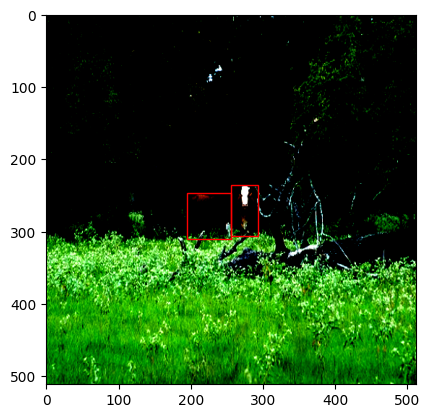

In [21]:
plot_data(img[0], dec_bboxes[0])

In [22]:
classes[0]

tensor([10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0])